In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

# Load libraries and set device engine

In [2]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import cv2
import gc
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


# Load Dataset and split data

In [4]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [5]:
df = pd.read_csv(f"data/california_housing.csv")

In [6]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [7]:
# Function to load and preprocess data
def load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=32):
    
    X_train, X_val = train_test_split(df, test_size=0.20, random_state=SEED)
    X_val, X_test = train_test_split(X_val, test_size=0.50, random_state=SEED)
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    
    ### X_train
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        #Generate thet images
        image_model.fit_transform(X_train, f'{images_folder}/train')
        image_model.saveHyperparameters(f'{images_folder}'+"/model.pkl")
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/train',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)
    
    # Update image paths
    imgs["images"] = images_folder + "/train/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_train], axis=1)

    # Split data
    X_train = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_train = combined_dataset["values"]
        
    ### X_val
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/val'):
        #Generate thet images
        image_model.transform(X_val, f'{images_folder}/val')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/val',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/val/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_val], axis=1)

    # Split data
    X_val = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_val = combined_dataset["values"]
    
    ### X_test
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/test'):
        #Generate thet images
        image_model.transform(X_test, f'{images_folder}/test')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/test',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/test/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_test], axis=1)

    # Split data
    X_test = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_test = combined_dataset["values"]
    
    # Numerical data
    X_train_num = X_train.drop("images", axis=1)
    X_val_num = X_val.drop("images", axis=1)
    X_test_num = X_test.drop("images", axis=1)

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

    ## Create a MinMaxScaler object
    scaler = MinMaxScaler()

    ## Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)
    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Normalize to [0, 1]
    X_train_img_tensor = X_train_img_tensor / 255.0
    X_val_img_tensor = X_val_img_tensor / 255.0
    X_test_img_tensor = X_test_img_tensor / 255.0

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape 


In [8]:
batch_size = 32
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

3


In [9]:
from TINTOlib.igtd import IGTD
dataset_name = 'california_housing'
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', error='abs', max_step=30000, val_step=300, random_seed=SEED)

name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [10]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
HyNNImages/Regression/california_housing/images_california_housing_IGTD_3x3_fEuclidean_iEuclidean_abs/train\regression.csv
The images are already generated
HyNNImages/Regression/california_housing/images_california_housing_IGTD_3x3_fEuclidean_iEuclidean_abs/val\regression.csv
The images are already generated
HyNNImages/Regression/california_housing/images_california_housing_IGTD_3x3_fEuclidean_iEuclidean_abs/test\regression.csv
Images shape:  (3, 3, 3)
Attributes:  8


In [11]:
class Model1(nn.Module):
    def __init__(self, imgs_shape, device):
        super(Model1, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 32, kernel_size=2),
            nn.ReLU(),
            nn.Flatten()
        ).to(device)

        self.device = device
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_mlp = nn.Sequential(
            nn.Linear(self.flat_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        ).to(device)
        
    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def forward(self, x):
        cnn_input = x.to(self.device)
        cnn_output = self.cnn_branch(cnn_input)
        final_output = self.final_mlp(cnn_output)
        return final_output

In [57]:
class Model2(nn.Module):
    def __init__(self, imgs_shape, device):
        super(Model2, self).__init__()
        self.device = device
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=64, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 32, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        ).to(device)
        
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Dense layers
        self.final_mlp = nn.Sequential(
            nn.Linear(self.flat_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        ).to(device)

    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def forward(self, x):
        cnn_input = x.to(self.device)
        # CNN branch
        cnn_output = self.cnn_branch(cnn_input)
        
        final_output = self.final_mlp(cnn_output)
        return final_output

In [11]:
import traceback

def try_create_model(model_class, imgs_shape, device):
    try:
        model = model_class(imgs_shape, device)
        
        # Test the model with a sample input
        sample_input = torch.randn(4, *imgs_shape)
        output = model(sample_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}: {str(e)}")
        traceback.print_exc()
        return None

# Compile and FIT

In [12]:
def compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=32, epochs=100, min_lr=1e-3, max_lr=1, device='cuda', weight_decay=1e-2):
    model = model
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=max_lr/min_lr, total_steps=total_steps, pct_start=0.3, final_div_factor=1)

    best_val_loss = float('inf')
    best_val_rmse = float('inf')
    best_model = None
    best_epoch = 0

    history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': [], 'train_rmse': [], 'val_rmse': [], 'learning_rate': [], 'epoch_time': []}

    start_time = time.time()
    
    pbar = tqdm(range(epochs), desc='description', ncols=100)
    for epoch in pbar:
    #for epoch in range(epochs):
        epoch_start_time = time.time()

        # Training phase
        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        
        for _, img_data, targets in train_loader:  # Only take image and targets
            img_data, targets = img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(img_data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        
        with torch.no_grad():
            for _, img_data, targets in val_loader:
                img_data, targets = img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                outputs = model(img_data)
                loss = loss_fn(outputs, targets)
                
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()

        # Compute metrics
        train_mse = mean_squared_error(train_targets, train_predictions)
        train_rmse = np.sqrt(train_mse)
        val_mse = mean_squared_error(val_targets, val_predictions)
        val_rmse = np.sqrt(val_mse)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_rmse = val_rmse
            best_model = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1

        epoch_time = time.time() - epoch_start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)
        history['train_rmse'].append(train_rmse)
        history['val_rmse'].append(val_rmse)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)

        pbar.set_description("train_rmse: %.2e | val_rmse: %.2e" %
                                 (train_rmse,
                                  val_rmse))

    total_time = time.time() - start_time
    model.load_state_dict(best_model)

    # Calculate and save metrics
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)

    # Save metrics
    metrics = {
        'train_loss': train_metrics['loss'],
        'train_mse': train_metrics['mse'],
        'train_mae': train_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'val_loss': val_metrics['loss'],
        'val_mse': val_metrics['mse'],
        'val_mae': val_metrics['mae'],
        'val_rmse': val_metrics['rmse'],
        'test_loss': test_metrics['loss'],
        'test_mse': test_metrics['mse'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }
    
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch}/{epochs} best_val_rmse:{best_val_rmse}")

    # Save model
    model_save_path = f"models/Regression/{dataset_name}/ViT+MLP/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model, model_save_path)
    print(f"Best model saved to {model_save_path}")
            
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return metrics


In [13]:
def calculate_metrics(model, data_loader, device):
    model.eval()
    loss_fn = nn.MSELoss()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for _, img_data, targets in data_loader:  # Ignore numerical data
            img_data, targets = img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(img_data)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    return {
        'loss': total_loss / len(data_loader),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }    

In [16]:
model1 = try_create_model(Model1, imgs_shape, device)  # Attempt to create Model1

Successfully created and tested Model1


In [17]:
model1_metrics = compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-6, max_lr=4e-3, epochs=60)  # Train and evaluate Model1

train_rmse: 5.94e-01 | val_rmse: 6.31e-01: 100%|████████████████████| 60/60 [06:30<00:00,  6.51s/it]



Training completed in 390.46 seconds
Best model found at epoch 53/60 best_val_rmse:0.6142899394035339
Best model saved to models/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model1/best_model.pth


In [58]:
model2 = try_create_model(Model2, imgs_shape, device)  # Attempt to create Model2

Successfully created and tested Model2


In [59]:
model2_metrics = compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-6, max_lr=4e-3, epochs=70)  # Train and evaluate Model1

train_rmse: 5.45e-01 | val_rmse: 5.91e-01: 100%|████████████████████| 70/70 [01:29<00:00,  1.28s/it]



Training completed in 89.66 seconds
Best model found at epoch 62/70 best_val_rmse:0.5815129280090332
Best model saved to models/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model2/best_model.pth


In [66]:
model2_metrics = compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-6, max_lr=4e-3, epochs=80)  # Train and evaluate Model1

train_rmse: 5.43e-01 | val_rmse: 6.02e-01: 100%|████████████████████| 80/80 [01:34<00:00,  1.18s/it]



Training completed in 94.16 seconds
Best model found at epoch 73/80 best_val_rmse:0.5840596556663513
Best model saved to models/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model2/best_model.pth


In [52]:
model2_metrics = compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-6, max_lr=4e-3, epochs=80)  # Train and evaluate Model1

train_rmse: 5.36e-01 | val_rmse: 5.97e-01: 100%|████████████████████| 80/80 [01:30<00:00,  1.13s/it]



Training completed in 90.55 seconds
Best model found at epoch 70/80 best_val_rmse:0.57527095079422
Best model saved to models/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model2/best_model.pth


# TestHibrid

In [22]:
class Model3(nn.Module):
    def __init__(self, imgs_shape, device):
        super(Model3, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Flatten()
        ).to(device)

        self.device = device
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final KAN layers
        self.final_kan = KAN(
            width=[self.flat_size, 12, 1],
            grid=8,
            k=3,
            seed=SEED,
            device=device
        )
        
    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=self.device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def forward(self, x):
        cnn_input = x.to(self.device)
        cnn_output = self.cnn_branch(cnn_input)
        final_output = self.final_kan(cnn_output)
        return final_output


In [23]:
class Model5(nn.Module):
    def __init__(self, imgs_shape, device):
        super(Model5, self).__init__()
        # Final KAN layers
        self.final_kan = KAN(
            width=[imgs_shape[0], 12, 1],
            grid=8,
            k=3,
            seed=SEED,
            device=device
        )

    def forward(self, x):
        return x.final_kan(self.device)


In [15]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (img_tensor, target_tensor)
    """
    img_list, target_list =  [], []
    for _, img, target in loader:
        img_list.append(img)
        target_list.append(target)
    return torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

In [16]:
# Combine dataloaders into tensors.
train_img, train_target = combine_loader(train_loader)
val_img, val_target = combine_loader(val_loader)
test_img, test_target = combine_loader(test_loader)

dataset = {
    "train_img": train_img.to(device),
    "train_target": train_target.to(device),
    "val_img": val_img.to(device),
    "val_target": val_target.to(device),
    "test_img": test_img.to(device),
    "test_target": test_target.to(device),
}

In [17]:
import os
import time
import copy
import numpy as np
import torch
import torch.optim as optim
from torch.optim import LBFGS
from tqdm import tqdm
import matplotlib.pyplot as plt


def fit_model_dataloaders(model, 
                           dataset, 
                           opt="LBFGS", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None):
    """
    Trains Model3, which consists of a CNN branch followed by a final KAN.
    
    DataLoaders are assumed to yield batches of (img, target).
    
    The training loop follows a steps-based paradigm (similar to KAN.fit) and includes:
      - A closure for LBFGS (if selected) or a standard Adam update,
      - Periodic grid updates (applied to final_kan using the CNN output),
      - Regularization updates and optional visualization.
    
    Returns:
      results: A dictionary with training loss, evaluation loss, regularization, and any extra metrics.
    """
    device = next(model.parameters()).device

    # Warn if regularization is requested but final_kan's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.final_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.final_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.final_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (MSE) if not provided.
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency.
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Total number of training examples.
    n_train = dataset["train_img"].shape[0]
    n_eval  = dataset["test_img"].shape[0]  # using test set for evaluation during training.
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up the optimizer.
    if opt == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {
        'train_loss': [],
        'eval_loss': [],
        'reg': []
    }
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set.
        eval_indices = np.arange(n_eval)

        # Closure for LBFGS.
        def closure():
            optimizer.zero_grad()
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_target"][train_indices]
            outputs = model(img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.final_kan.node_attribute()
                reg_val_inner = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            return loss_val_inner

        # Perform grid update if conditions are met.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            # Pass the CNN output (flattened) for grid update.
            with torch.no_grad():
                cnn_batch = model.cnn_branch(dataset["train_img"][train_indices])
            model.final_kan.update_grid(cnn_batch)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = closure()  # re-evaluate for logging.
            with torch.no_grad():
                img_batch = dataset["train_img"][train_indices]
                target_batch = dataset["train_target"][train_indices]
                outputs = model(img_batch)
                train_loss = loss_fn(outputs, target_batch)
                if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                    if reg_metric == 'edge_backward':
                        model.final_kan.attribute()
                    if reg_metric == 'node_backward':
                        model.final_kan.node_attribute()
                    reg_val = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                    if torch.isnan(reg_val).any():
                        print("Warning: reg_val is NaN, setting it to 0.")
                        reg_val = torch.tensor(0., device=device)

                else:
                    reg_val = torch.tensor(0., device=device)
        else:  # Adam branch.
            optimizer.zero_grad()
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_target"][train_indices]
            outputs = model(img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.final_kan.node_attribute()
                reg_val = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()


        
        # Evaluate on the entire evaluation set.
        img_eval = dataset["test_img"][eval_indices]
        target_eval = dataset["test_target"][eval_indices]
        eval_loss = loss_fn(model(img_eval), target_eval)

        # Record the results (using square-root of loss, as in KAN.fit).
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        if metrics is not None:
            for metric in metrics:
                results[metric.__name__].append(metric().item())

        # Update progress bar description.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.final_kan, "save_act", False)
            model.final_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.final_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.final_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.final_kan, "log_history"):
        model.final_kan.log_history('fit')

    return results


In [233]:
torch.autograd.set_detect_anomaly(False)

In [24]:
model3 = try_create_model(Model3, imgs_shape, device)

checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


In [25]:
model5 = try_create_model(Model5, imgs_shape, device)

checkpoint directory created: ./model
saving model version 0.0
Error creating or testing Model5: 'Tensor' object has no attribute 'final_kan'


Traceback (most recent call last):
  File "C:\Users\vgiov\AppData\Local\Temp\ipykernel_22596\2679069357.py", line 9, in try_create_model
    output = model(sample_input)
             ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\vgiov\anaconda3\envs\env_torch_12\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\vgiov\anaconda3\envs\env_torch_12\Lib\site-packages\torch\nn\modules\module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\vgiov\AppData\Local\Temp\ipykernel_22596\1674806975.py", line 14, in forward
    return x.final_kan(self.device)
           ^^^^^^^^^^^
AttributeError: 'Tensor' object has no attribute 'final_kan'


In [19]:
model3_metrics = compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-6, max_lr=4e-3, epochs=8)  # Train and evaluate Model1

description:   0%|                                                            | 0/8 [01:37<?, ?it/s]


KeyboardInterrupt: 

In [259]:
metrics = fit_model_dataloaders(model3, dataset, opt="LBFGS", steps=25, update_grid=True) #0 y 2

| train_loss: nan | eval_loss: nan | reg: 0.00e+00 |:  20%|██        | 5/25 [00:09<00:39,  1.96s/it]


KeyboardInterrupt: 

In [73]:
metrics = fit_model_dataloaders(model3, dataset, opt="LBFGS", lamb=0., lamb_entropy=100, steps=25, update_grid=False) #0 y 2

| train_loss: 6.02e-01 | eval_loss: 6.38e-01 | reg: 0.00e+00 |: 100%|█| 25/25 [01:39<00:00,  3.98s/i

saving model version 0.1


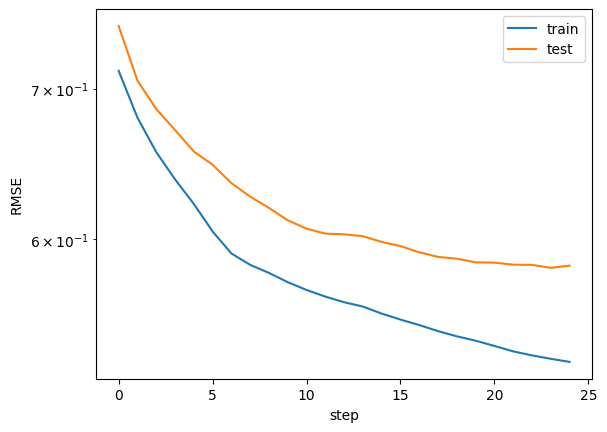

In [249]:
plt.plot(metrics['train_loss'])
plt.plot(metrics['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [252]:
class Model4(nn.Module):
    def __init__(self, imgs_shape, device):
        super(Model4, self).__init__()
        self.device = device
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=64, kernel_size=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        ).to(device)
        
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final KAN layers
        self.final_kan = KAN(
            width=[self.flat_size, 12, 1],
            grid=8,
            k=3,
            seed=SEED,
            device=device
        )

    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def forward(self, x):
        cnn_input = x.to(self.device)
        # CNN branch
        cnn_output = self.cnn_branch(cnn_input)
        
        final_output = self.final_kan(cnn_output)
        return final_output

In [253]:
model4 = try_create_model(Model4, imgs_shape, device) 

checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


In [254]:
metrics = fit_model_dataloaders(model4, dataset, opt="LBFGS", lamb=0., steps=50, update_grid=False) #0 y 2

| train_loss: 4.75e-01 | eval_loss: 5.79e-01 | reg: 0.00e+00 |: 100%|█| 50/50 [01:00<00:00,  1.20s/i

saving model version 0.1


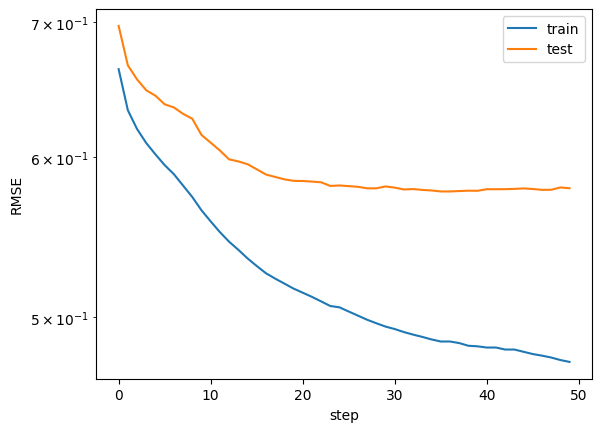

In [255]:
plt.plot(metrics['train_loss'])
plt.plot(metrics['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

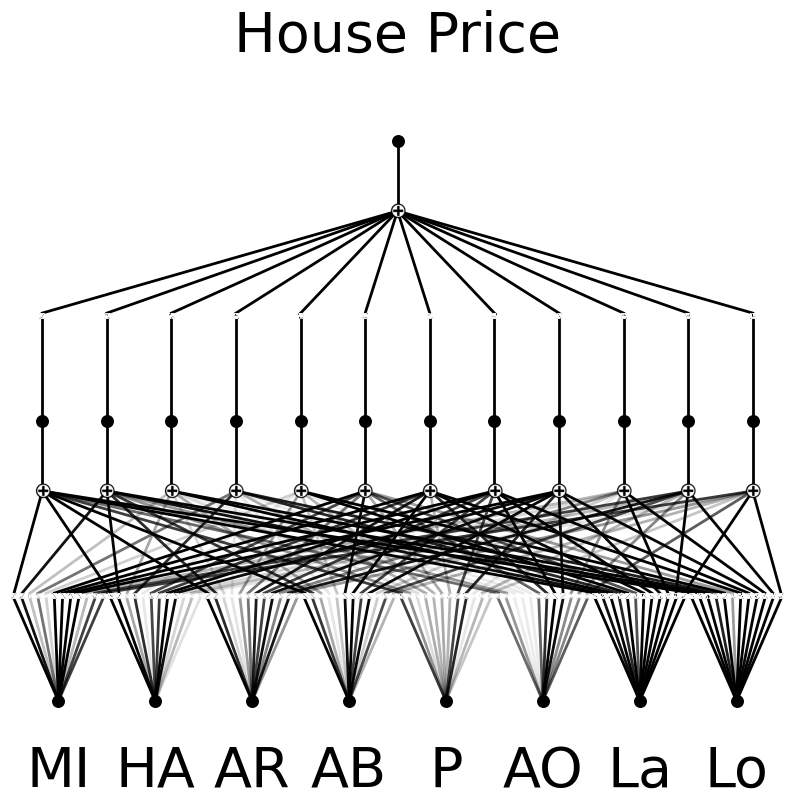

In [124]:
model.plot(beta=50, scale=1,in_vars=input_vars, out_vars=['House Price'])

# Show symbolic formula generated

In [125]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with x, r2=0.9765904545783997, c=1
fixing (0,0,1) with x, r2=0.680465817451477, c=1
fixing (0,0,2) with x, r2=0.30162280797958374, c=1
fixing (0,0,3) with x, r2=0.7910828590393066, c=1
fixing (0,0,4) with x, r2=0.7882108688354492, c=1
fixing (0,0,5) with x, r2=0.9033933877944946, c=1
fixing (0,0,6) with x, r2=0.8512812852859497, c=1
fixing (0,0,7) with sin, r2=0.9786099195480347, c=2
fixing (0,0,8) with x, r2=0.7940358519554138, c=1
fixing (0,0,9) with x, r2=0.8807955384254456, c=1
fixing (0,0,10) with sin, r2=0.9662820100784302, c=2
fixing (0,0,11) with x, r2=0.9679688811302185, c=1
fixing (0,1,0) with x, r2=0.8030456900596619, c=1
fixing (0,1,1) with x, r2=0.8620676398277283, c=1
fixing (0,1,2) with x, r2=0.8049867153167725, c=1
fixing (0,1,3) with x, r2=0.8315892219543457, c=1
fixing (0,1,4) with sin, r2=0.9514980912208557, c=2
fixing (0,1,5) with x, r2=0.1296408772468567, c=1
fixing (0,1,6) with x, r2=0.36357271671295166, c=1
fixing (0,1,7) with x, r2=0.8230635523796

0.3431*x_1 - 0.0797*x_2 + 0.2743*x_3 - 0.0964*x_4 - 0.003*x_5 - 0.0562*x_6 - 0.5932*x_7 - 0.4589*x_8 - 0.0356*sin(0.5831*x_1 + 7.0167) - 0.0015*sin(1.7178*x_2 - 1.7947) + 0.0006*sin(1.8226*x_6 + 1.8284) + 0.0428*sin(2.6116*x_6 - 1.4098) + 0.0018*sin(2.6193*x_6 + 1.5833) + 0.0642*sin(2.994*x_6 - 7.5881) - 0.1204*sin(3.3682*x_6 + 4.9941) + 0.0067*sin(3.405*x_6 - 7.5914) + 0.0204*sin(3.9885*x_6 + 5.0028) + 0.0742*sin(5.0002*x_6 + 5.0027) + 1.715

# Show Feature Importance

In [126]:
model.feature_score

tensor([0.7730, 0.3418, 0.4180, 0.3838, 0.1135, 0.5291, 1.6611, 1.4451],
       device='cuda:0', grad_fn=<MeanBackward1>)